<a href="https://colab.research.google.com/github/B10956048/113_Finance/blob/main/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 作業1：使用 LSTM 模型預測股票未來價格，自訂窗口大小，並分析預測效果。

In [15]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# 下載股票資料 (2454.TW)
data = yf.download('2454.TW', start='2020-01-01', end='2023-01-01')
closing_prices = data['Close'].values.reshape(-1, 1)

#closing_prices

[*********************100%***********************]  1 of 1 completed


In [16]:
# 標準化資料
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(closing_prices)

In [17]:
# 建立訓練集和測試集（使用 20 天的收盤價來預測第 21 天的收盤價）
def create_sequences(data, seq_length=20):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_prices, seq_length)

# 將資料轉換為 Tensor 格式
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 分割訓練集與測試集
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
 #定義 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(x.device)
        _, (hn, _) = self.lstm(x, (h_0, c_0))
        out = self.linear(hn[-1])
        return out

# 初始化模型、損失函數和優化器
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練 LSTM 模型
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')

# 預測結果
model.eval()
train_predictions, test_predictions = [], []

# 生成訓練集預測
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        train_predictions.append(model(X_batch))
train_predictions = torch.cat(train_predictions).cpu().numpy()
train_predictions = scaler.inverse_transform(train_predictions)

# 生成測試集預測
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        test_predictions.append(model(X_batch))
test_predictions = torch.cat(test_predictions).cpu().numpy()
test_predictions = scaler.inverse_transform(test_predictions)

# 反標準化實際數據
train_y_actual = scaler.inverse_transform(train_y.cpu().numpy())
test_y_actual = scaler.inverse_transform(test_y.cpu().numpy())

Epoch 1/100, Loss: 0.1270
Epoch 2/100, Loss: 0.0416
Epoch 3/100, Loss: 0.0310
Epoch 4/100, Loss: 0.0170
Epoch 5/100, Loss: 0.0080
Epoch 6/100, Loss: 0.0060
Epoch 7/100, Loss: 0.0045
Epoch 8/100, Loss: 0.0037
Epoch 9/100, Loss: 0.0028
Epoch 10/100, Loss: 0.0024
Epoch 11/100, Loss: 0.0022
Epoch 12/100, Loss: 0.0021
Epoch 13/100, Loss: 0.0018
Epoch 14/100, Loss: 0.0017
Epoch 15/100, Loss: 0.0017
Epoch 16/100, Loss: 0.0017
Epoch 17/100, Loss: 0.0017
Epoch 18/100, Loss: 0.0017
Epoch 19/100, Loss: 0.0017
Epoch 20/100, Loss: 0.0016
Epoch 21/100, Loss: 0.0016
Epoch 22/100, Loss: 0.0016
Epoch 23/100, Loss: 0.0015
Epoch 24/100, Loss: 0.0015
Epoch 25/100, Loss: 0.0015
Epoch 26/100, Loss: 0.0015
Epoch 27/100, Loss: 0.0015
Epoch 28/100, Loss: 0.0014
Epoch 29/100, Loss: 0.0015
Epoch 30/100, Loss: 0.0015
Epoch 31/100, Loss: 0.0014
Epoch 32/100, Loss: 0.0013
Epoch 33/100, Loss: 0.0014
Epoch 34/100, Loss: 0.0014
Epoch 35/100, Loss: 0.0013
Epoch 36/100, Loss: 0.0013
Epoch 37/100, Loss: 0.0013
Epoch 38/1

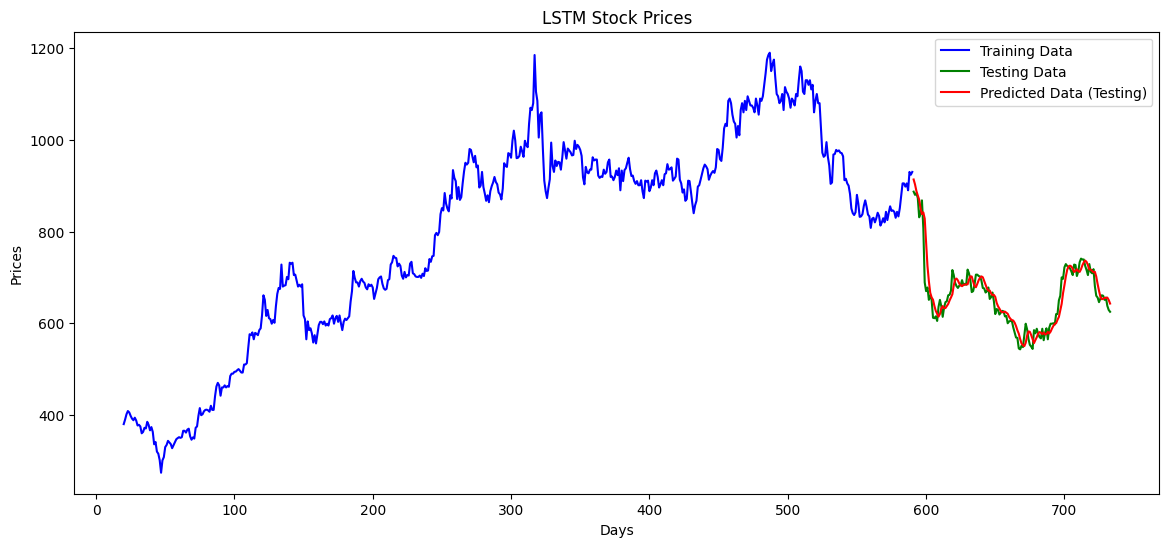

In [20]:
# 視覺化結果
import matplotlib.pyplot as plt

# 繪圖
plt.figure(figsize=(14, 6))

# 繪製訓練集真實數據
plt.plot(range(seq_length, seq_length + len(train_y_actual)), train_y_actual, label='Training Data', color='blue')

# 繪製測試集真實數據
plt.plot(range(seq_length + len(train_y_actual), seq_length + len(train_y_actual) + len(test_y_actual)), test_y_actual,
         label='Testing Data', color='green')

# 繪製訓練集預測數據
#plt.plot(range(seq_length, seq_length + len(train_predictions)), train_predictions, label='Predicted Data (Training)', color='red', alpha=0.6)

# 繪製測試集預測數據
plt.plot(range(seq_length + len(train_y_actual), seq_length + len(train_y_actual) + len(test_predictions)), test_predictions,
         label='Predicted Data (Testing)', color='red')

# 標題和標籤
plt.title('LSTM Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

### 作業2：使用 Transformer 模型預測股價漲跌，自訂窗口大小，並分析預測結果。

In [48]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 下載股票資料 (2330.TW)
data = yf.download('2454.TW', start='2020-01-01', end='2023-01-01')
closing_prices = data['Close'].values.reshape(-1, 1)

# 標準化資料
scaler = StandardScaler()
scaled_prices = scaler.fit_transform(closing_prices)

[*********************100%***********************]  1 of 1 completed


In [49]:
# 建立訓練集和測試集（使用 20 天的收盤價來預測第 21 天的收盤價）
def create_sequences(data, seq_length=20):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(scaled_prices, seq_length)

# 將資料轉換為 Tensor 格式
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# 分割訓練集與測試集
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [50]:
# 定義位置編碼（Positional Encoding）
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

# 定義改進版 Transformer 模型
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, num_layers=2, output_size=1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead), num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        # 加入位置編碼
        x = self.embedding(x)
        x = self.pos_encoder(x.permute(1, 0, 2) * np.sqrt(self.d_model))
        x = self.transformer(x)
        x = x.mean(dim=0)  # 將時間維度上取平均，得到 (batch_size, d_model)
        out = self.fc(x)
        return out

# 初始化模型、損失函數和優化器
model = TransformerModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練 Transformer 模型
epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}')

# 預測結果
model.eval()
train_predictions, test_predictions = [], []

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/100, Loss: 0.2609
Epoch 2/100, Loss: 0.0718
Epoch 3/100, Loss: 0.0600
Epoch 4/100, Loss: 0.0529
Epoch 5/100, Loss: 0.0469
Epoch 6/100, Loss: 0.0491
Epoch 7/100, Loss: 0.0377
Epoch 8/100, Loss: 0.0299
Epoch 9/100, Loss: 0.0209
Epoch 10/100, Loss: 0.0192
Epoch 11/100, Loss: 0.0201
Epoch 12/100, Loss: 0.0155
Epoch 13/100, Loss: 0.0135
Epoch 14/100, Loss: 0.0131
Epoch 15/100, Loss: 0.0181
Epoch 16/100, Loss: 0.0159
Epoch 17/100, Loss: 0.0148
Epoch 18/100, Loss: 0.0167
Epoch 19/100, Loss: 0.0168
Epoch 20/100, Loss: 0.0131
Epoch 21/100, Loss: 0.0142
Epoch 22/100, Loss: 0.0117
Epoch 23/100, Loss: 0.0180
Epoch 24/100, Loss: 0.0176
Epoch 25/100, Loss: 0.0114
Epoch 26/100, Loss: 0.0129
Epoch 27/100, Loss: 0.0193
Epoch 28/100, Loss: 0.0143
Epoch 29/100, Loss: 0.0149
Epoch 30/100, Loss: 0.0158
Epoch 31/100, Loss: 0.0155
Epoch 32/100, Loss: 0.0135
Epoch 33/100, Loss: 0.0117
Epoch 34/100, Loss: 0.0156
Epoch 35/100, Loss: 0.0144
Epoch 36/100, Loss: 0.0150
Epoch 37/100, Loss: 0.0128
Epoch 38/1

In [51]:
# 生成訓練集預測
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        train_predictions.append(model(X_batch))
train_predictions = torch.cat(train_predictions).cpu().numpy()
train_predictions = scaler.inverse_transform(train_predictions)

# 生成測試集預測
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        test_predictions.append(model(X_batch))
test_predictions = torch.cat(test_predictions).cpu().numpy()
test_predictions = scaler.inverse_transform(test_predictions)

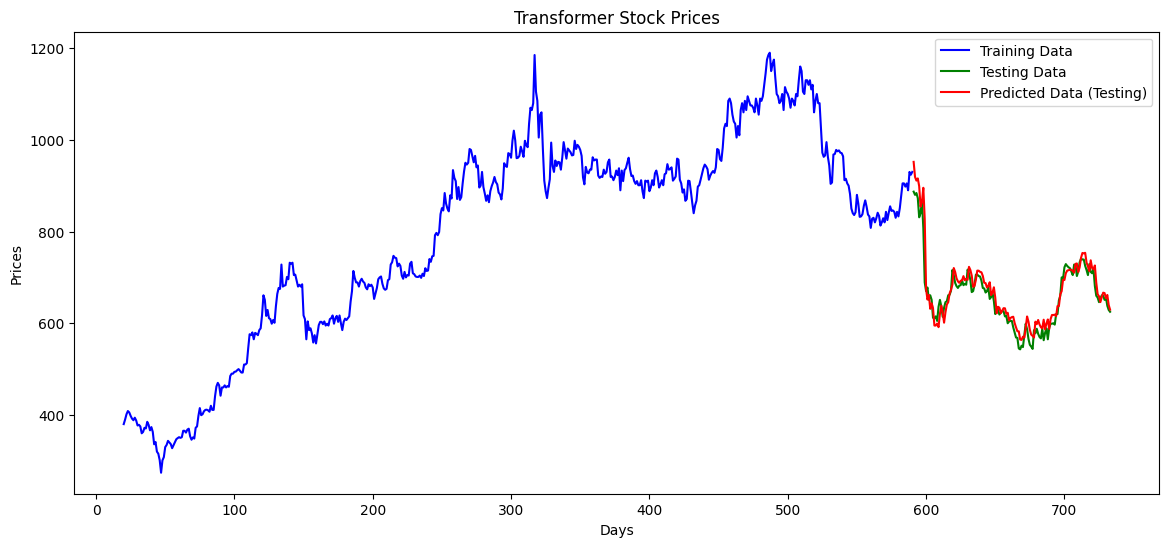

In [52]:
# 反標準化實際數據
train_y_actual = scaler.inverse_transform(train_y.cpu().numpy())
test_y_actual = scaler.inverse_transform(test_y.cpu().numpy())

# 繪圖
plt.figure(figsize=(14, 6))

# 繪製訓練集真實數據
plt.plot(range(seq_length, seq_length + len(train_y_actual)), train_y_actual, label='Training Data', color='blue')

# 繪製測試集真實數據
plt.plot(range(seq_length + len(train_y_actual), seq_length + len(train_y_actual) + len(test_y_actual)), test_y_actual,
         label='Testing Data', color='green')

# 繪製訓練集預測數據
#plt.plot(range(seq_length, seq_length + len(train_predictions)), train_predictions, label='Predicted Data (Training)', color='red', linestyle='--')

# 繪製測試集預測數據
plt.plot(range(seq_length + len(train_y_actual), seq_length + len(train_y_actual) + len(test_predictions)), test_predictions,
         label='Predicted Data (Testing)', color='red')

# 標題和標籤
plt.title('Transformer Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()
